In [44]:
import json
import os
from enum import Enum
from typing import List, Optional, Literal, Dict

from IPython.display import display, Image
from dotenv import load_dotenv
from langchain.prompts import PromptTemplate
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import PyPDFLoader
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.output_parsers import JsonOutputParser
from langchain_ollama import ChatOllama
from langgraph.graph import START, END, StateGraph, MessagesState
from pydantic import BaseModel, Field
from typing_extensions import TypedDict, Annotated
import operator
from src.services.retrival_engine import RetrivalEngine
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.document_loaders import WikipediaLoader
from langchain_core.messages import get_buffer_string

os.environ.clear()
load_dotenv()

True

In [45]:
import pandas as pd

df_2 = pd.read_excel('urls.xlsx')
df_2

,urls
0,https://drive.google.com/file/d/1ntkwGeHmmkyQX...
1,https://drive.google.com/file/d/1ncu7OPrXB2i3n...
2,https://drive.google.com/file/d/199F9gjwuSCNRC...


# LLM

In [46]:
local_llm = "llama3.2:latest"
model_tested = "llama3.2:latest"
metadata = f"CRAG, {model_tested}"

# Create Index
Let's index 3 blog posts

In [4]:
# urls = [
#     "https://lpi.oregonstate.edu/sites/lpi.oregonstate.edu/files/pdf/mic/micronutrients_for_health.pdf",
#     # "https://www.accessdata.fda.gov/scripts/InteractiveNutritionFactsLabel/assets/InteractiveNFL_Vitamins%26MineralsChart_October2021.pdf",
#
#     "https://www.hilarispublisher.com/open-access/essential-nutrients-in-human-body.pdf",
# ]
#
# # Load documents from the URLs
# docs = [PyPDFLoader(url).load() for url in urls]
# docs_list = [item for sublist in docs for item in sublist]
#
# # Initialize a text splitter with specified chunk size and overlap
# text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
#     chunk_size=600, chunk_overlap=100
# )
#
# # Create a retrival Engine
# retrival_engine = RetrivalEngine()
#
# # Split the documents into chunks
# doc_splits = text_splitter.split_documents(docs_list)
#
# contents = [doc.page_content for doc in doc_splits]
# metadatas = []
#
# for doc in doc_splits:
#     metadata = dict(doc.metadata)
#     metadata["content"] = "nutrition_article"
#     metadatas.append(metadata)
#
# # Add items to retrival engine in smaller batches
# batch_size = 10
# for i in range(0, len(contents), batch_size):
#     batch_contents = contents[i:i + batch_size]
#     batch_metadatas = metadatas[i:i + batch_size]
#
#     # This will use the cache for any existing embeddings
#     ids = retrival_engine.bulk_add_items(
#         contents=batch_contents,
#         metadatas=batch_metadatas,
#         item_types=["nutrition_document"] * len(batch_contents)
#     )
#
# print("All documents stored in Pinecone!")


# Building the graph

## Document retriver

In [47]:
class UserProfile(BaseModel):
    name: Optional[str] = Field(None, description="User's full name")
    age: int = Field(..., ge=0, le=120, description="User's age")
    gender: str = Field(..., description="Male, Female, or Other")
    height_cm: int = Field(..., gt=50, lt=250, description="Height in cm")
    weight_kg: float = Field(..., gt=20, lt=300, description="Weight in kg")
    activity_level: str = Field(...,
                                description="Sedentary, Lightly active, Moderately active, Very active, Super active")
    dietary_preferences: List[Literal[
        "Vegetarian", "Vegan", "Pescatarian", "Keto", "Paleo",
        "Gluten-Free", "Dairy-Free", "Nut-Free", "Halal", "Kosher",
        "Low-Carb", "Low-Fat", "High-Protein", "Mediterranean", "FODMAP", "Sugar-Free"
    ]] = Field(default=[], description="User's dietary preferences, can be one or more.")
    allergies: List[str] = Field(default=[], description="User's allergies")
    health_conditions: List[str] = Field(default=[], description="Any medical conditions")
    weight_goal: str = Field(..., description="Lose weight, Maintain weight, Gain muscle")
    past_meals: List[str] = Field(default=[], description="Past meals")


user_profile = {
    "name": "Space Cadet",
    "age": 23,
    "gender": "Male",
    "height_cm": 183,
    "weight_kg": 65,
    "activity_level": "Lightly active",
    "dietary_preferences": ["Dairy-Free", "Low-Carb"],
    "allergies": ["Peanuts"],
    "health_conditions": ["None"],
    "weight_goal": "Maintain weight"
}

user = UserProfile(**user_profile)
past_meals = []
print(user.model_dump_json(indent=4))

{
    "name": "Space Cadet",
    "age": 23,
    "gender": "Male",
    "height_cm": 183,
    "weight_kg": 65.0,
    "activity_level": "Lightly active",
    "dietary_preferences": [
        "Dairy-Free",
        "Low-Carb"
    ],
    "allergies": [
        "Peanuts"
    ],
    "health_conditions": [
        "None"
    ],
    "weight_goal": "Maintain weight",
    "past_meals": []
}


In [48]:
llm = ChatOllama(model=local_llm, format="json", temperature=0)
llm_json_mode = ChatOllama(model=local_llm, format="json", temperature=0)

# Retrieval Prompt Template for Multiple Meal Plans
retriever_prompt = PromptTemplate(
    template="""
    You are a nutritionist AI assistant that helps users generate **personalized meal recommendations** based on their profile.

    The user profile is as follows:

    - Age: {age}
    - Gender: {gender}
    - Height: {height_cm} cm
    - Weight: {weight_kg} kg
    - Activity Level: {activity_level}
    - Dietary Preferences: {dietary_preferences}
    - Allergies: {allergies}
    - Health Conditions: {health_conditions}
    - Weight Goal: {weight_goal}
    - Past Meal History (if available): {past_meals}

    ### Task:
    Generate a structured JSON response with **multiple queries** for retrieving meal plans.
    Each query should focus on **one meal category**:
    - Breakfast
    - Lunch
    - Dinner
    - Snacks

    Ensure that meals align with **dietary preferences, allergies, and weight goals** while maintaining **nutritional balance**.

    Rules:
	•	If any field is an empty array `[]`, or unspecified, substitute it with a realistic, healthy default (e.g., “Mediterranean diet”, “moderately active”, “no known allergies”, etc.).
	•	If dietary preference is missing, randomly choose a healthy eating pattern such as Mediterranean, Plant-based, Paleo, or Flexitarian.
	•	Ensure that meals align with all available preferences, allergies, and weight goals while maintaining nutritional balance.


    Your output must be a valid JSON object structured as follows:
    ```json
    {{
        "queries": [
            {{
                "meal_type": "BREAKFAST",
                "query": "Retrieve high-protein breakfast meals suitable for {gender}, {age} years old, {activity_level} activity, avoiding {allergies}."
            }},
            {{
                "meal_type": "LUNCH",
                "query": "Retrieve balanced lunch options with {dietary_preferences} for a {weight_goal} goal, avoiding {allergies}."
            }},
            {{
                "meal_type": "DINNER",
                "query": "Find nutritious dinners for {age}-year-old {gender} aiming to {weight_goal}."
            }},
            {{
                "meal_type": "SNACKS",
                "query": "Suggest healthy snack options that fit within a {dietary_preferences} diet while avoiding {allergies}."
            }}
        ]
    }}
    ```
    """,
    input_variables=[
        "age",
        "gender",
        "height_cm",
        "weight_kg",
        "activity_level",
        "dietary_preferences",
        "allergies",
        "health_conditions",
        "weight_goal",
        "past_meals"
    ],
)

# Output Parser
output_parser = JsonOutputParser()


class MealQuery(TypedDict):
    meal_type: Literal["BREAKFAST", "LUNCH", "DINNER"]
    query: str


# Function to Generate Multiple Queries
def generate_retrieval_queries(user_profile, llm) -> List[MealQuery]:
    formatted_prompt = retriever_prompt.format(**user_profile)
    response = llm.invoke(formatted_prompt)
    return output_parser.parse(response.content).get("queries", [])


# Example User Profile
# user_profile = {
#     "age": 28,
#     "gender": "Male",
#     "height_cm": 183,
#     "weight_kg": 65,
#     "activity_level": "Moderately active",
#     "dietary_preferences": [],
#     "allergies": [],
#     "health_conditions": [],
#     "weight_goal": "Maintain weight",
#     "past_meals": ["Oatmeal with fruits", "Grilled chicken with rice", "Salmon with vegetables"],
# }

user_profile = {
    "name": "Space Cadet",
    "age": 23,
    "gender": "Male",
    "height_cm": 183,
    "weight_kg": 65,
    "activity_level": "Lightly active",
    "dietary_preferences": ["Dairy-Free", "Low-Carb"],
    "allergies": ["Peanuts"],
    "health_conditions": ["None"],
    "weight_goal": "Maintain weight",
    "past_meals": ["Oatmeal with fruits", "Grilled chicken with rice", "Salmon with vegetables"],
}
# Generate queries
queries_info = generate_retrieval_queries(user_profile, llm_json_mode)
print(queries_info)

[{'meal_type': 'BREAKFAST', 'query': "Retrieve high-protein breakfast meals suitable for Male, 23 years old, Lightly active activity, avoiding ['Peanuts']."}, {'meal_type': 'LUNCH', 'query': "Retrieve balanced lunch options with ['Dairy-Free', 'Low-Carb'] for a Maintain weight goal, avoiding ['Peanuts']."}, {'meal_type': 'DINNER', 'query': 'Find nutritious dinners for 23-year-old Male aiming to Maintain weight.'}, {'meal_type': 'SNACKS', 'query': "Suggest healthy snack options that fit within a ['Dairy-Free', 'Low-Carb'] diet while avoiding ['Peanuts']."}]


In [49]:
# Function to get retrival docs
# Create a retrival Engine
retrival_engine = RetrivalEngine()


class RetrievedDocuments(BaseModel):
    meal_type: str
    query: str
    docs: List[str]


def retrieve_docs(queries_info, retriver):
    all_results = []
    for query_info in queries_info:
        query = query_info["query"]
        meal_type = query_info["meal_type"]
        retreived_docs = retriver.get_retrivals(query, top_k=2)
        all_results.append(RetrievedDocuments(meal_type=meal_type, query=query,
                                              docs=list(map(lambda x: x["metadata"]["content"], retreived_docs))))

    return all_results


queries_info = generate_retrieval_queries(user_profile, llm_json_mode)
results = retrieve_docs(queries_info, retrival_engine)
results

Loaded 29 cached embeddings
Using Pinecone for embeddings. Reason: Production environment
Using existing Pinecone index: recommendation-index
Loaded 4 cached retrieval results
Using cached retrieval results for: Retrieve high-protein breakfas...
Using cached retrieval results for: Retrieve balanced lunch option...
Using cached retrieval results for: Find nutritious dinners for 23...
Using cached retrieval results for: Suggest healthy snack options ...


[RetrievedDocuments(meal_type='BREAKFAST', query="Retrieve high-protein breakfast meals suitable for Male, 23 years old, Lightly active activity, avoiding ['Peanuts'].", docs=['raisins, peanut butter\nFluoridated water, crab meat, beans, \nblack tea, raisins, cereal, fish, fruit juice\nCod, iodized salt, potatoes (with skin), \nmilk, shrimp, turkey, navy beans, tuna, \neggs, seaweed\nBeef, fortified cereal, beans, oysters, \nmolasses, lentils, firm tofu, kidney beans, \ncashews, spinach, potatoes (with skin), \nshrimp, light tuna, eggs, tomatoes, dark-\nmeat chicken and turkey, raisins, prunes\n \nP\numpkin seeds, almonds, cashews, \nbeans, spinach, milk, figs, brown rice, \ncocoa powder, molasses, peanuts, \npineapple, okra, milk, bananas\nMen: 120 mg\nWomen: 90 mg \nPregnancy: 90 mg\nBreast-feeding: 90 mg\nAdults: 1,000 mg \nPregnancy: 1,000 mg\nBreast-feeding: 1,000 mg \nMen over 70: 1,200 mg\nWomen over 50: 1,200 mg\nMen: 35 mg\nMen over 50: 30 mg \nWomen: 25 mg \nPregnancy: 30 mg\

In [50]:
len(results)

4

## Router

In [51]:
router_instructions = """
You are an expert in routing user health profiles to the most relevant data source. Your task is to determine whether a query should be answered using a vectorstore or a web search.
	•	The vectorstore contains documents related to nutrition and food for health. Use this for queries specifically about diet, nutrition, or health-related food topics.
	•	For all other topics, especially current events, use web search as the data source.
	•	Your response must be a JSON object with a single key, datasource, whose value is either 'vectorstore' or 'websearch'. example: {"datasource": "vectorstore"} or {"datasource": "websearch"}

Ensure your decision-making is clear, accurate, and follows these rules strictly.
"""

# Testing
test_web_search = llm_json_mode.invoke(
    [SystemMessage(router_instructions), HumanMessage("What are the benefits of turmeric?")]
)
test_web_search2 = llm_json_mode.invoke(
    [SystemMessage(router_instructions), HumanMessage("Who is the president of the United States?")]
)
print(
    json.loads(test_web_search.content),
    json.loads(test_web_search2.content)
)

{'datasource': 'vectorstore'} {'datasource': 'websearch'}


## Retrival Grader

## Intializing Chat Gpt

In [52]:
from typing import Any, Union

load_dotenv()

from langchain_openai import ChatOpenAI

llm_chat = ChatOpenAI(
    model="gpt-4o",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
)

llm_chat_json = llm_chat.with_structured_output(method="json_mode")

In [53]:

# doc_grader_instructions = """
# You are a grader assessing the quality and relevance of a retrieved nutrition document to a user's profile and a specified meal type.
#
# Evaluate whether the document provides useful, accurate, and practical nutritional information that aligns with health and dietary topics, as well as the specified meal type.
#
# If the document contains scientifically valid and actionable insights on nutrition and is relevant to the given meal type, grade it as relevant.
# """

doc_grader_prompt = """
You are a grader assessing the quality and relevance of a retrieved nutrition document to a user's profile and a specified meal type.

Evaluate whether the document provides useful, accurate, and practical nutritional information that aligns with health and dietary topics, as well as the specified meal type.

If the document contains scientifically valid and actionable insights on nutrition and is relevant to the given meal type, grade it as relevant.


Here is the retrieved nutrition document: \n\n {document} \n\n
Here is the user's profile: \n\n {user_profile} \n\n if the users profile
Meal type: {meal_type} \n\n
Here is the grading criteria:
- The document should be scientifically accurate and credible.
- It should be relevant to nutrition and health-related topics.
- It should provide clear, actionable, and practical guidance.
- It should align with the specified meal type ({meal_type}).

Carefully and objectively assess whether the document meets these criteria.

Your answer should include:
1. A binary score of 'yes' or 'no'.
2. A reason of why you gave that score, based on the criteria.

Return JSON with a 2 keys, binary_score and reason as to why it reached that criteria
"""


class MealTypes(Enum):
    BREAKFAST = "Breakfast"
    LUNCH = "Lunch"
    DINNER = "Dinner"
    SNACKS = "Snacks"


# class DocumentMetadata(BaseModel):
#     content: str
#     creationdate: Optional[str]
#     creator: Optional[str]
#     item_type: str
#     moddate: Optional[str]
#     page: Optional[float]
#     page_label: Optional[str]
#     producer: Optional[str]
#     source: Optional[str]
#     total_pages: Optional[float]
#     trapped: Optional[str]

#
# class RetrievedDocumentsMetadata(BaseModel):
#     id: str
#     score: float
#     metadata: DocumentMetadata


# def grade_documents(user_profile, retrieve_docs, meal_type:MealTypes) -> GradedDocuments:
#     grade_documents:List[GradedDocuments] = []
#
#     for doc in retrieve_docs:
#         doc_content = doc["metadata"]["content"]
#         formatted_prompt = doc_grader_prompt.format(document=doc_content, user_profile=user_profile, meal_type=meal_type.value)
#         graded_response = llm_chat_json.invoke(formatted_prompt)
#
#
#     return grade_documents
#
# grade_documents = grade_documents(user_profile, results["BREAKFAST"], MealTypes.BREAKFAST)
class ValidatedDocument(BaseModel):
    valid: bool
    doc: Union[Optional[Dict[str, str]], Any]
    reaseon: Optional[str]


class GradedMealTypes(BaseModel):
    meal_type: str
    query: str
    validated_docs: List[ValidatedDocument]


class GraderResponse(BaseModel):
    binary_score: Literal["yes", "no"]
    reason: str


# function to grade the documents
def grade_documents(profile: UserProfile, retrieved_docs: List[RetrievedDocuments]) -> List[GradedMealTypes]:
    print(f"User profile: \n {profile}")
    result: List[GradedMealTypes] = []
    for retrieved_documents in retrieved_docs:
        meal_type = retrieved_documents.meal_type
        query = retrieved_documents.query
        to_input = GradedMealTypes(meal_type=meal_type, query=query, validated_docs=[])
        valid_docs: List[ValidatedDocument] = []

        print(f"===== checking for meal_type: {meal_type} =====")
        for index, doc_content in enumerate(retrieved_documents.docs):
            formatted_prompt = doc_grader_prompt.format(document=doc_content, meal_type=meal_type,
                                                        user_profile=json.dumps(profile, indent=4))

            graded_response = llm_chat_json.invoke(formatted_prompt)

            print(f"\tgraded_response for document {index + 1}: {graded_response["binary_score"]}")
            if graded_response["binary_score"] == "yes":
                print("\tThe document is:")
                print(f"\n\t\t{doc_content}")
                valid_docs.append(ValidatedDocument(valid=True, doc=doc_content, reaseon=graded_response["reason"]))
            else:
                print(f"\t\tThe document is: \n\t\t{doc_content}")
                valid_docs.append(ValidatedDocument(valid=False, doc=doc_content, reaseon=graded_response["reason"]))

        to_input.validated_docs = valid_docs

        result.append(to_input)

    return result


grade_meal_documents = grade_documents(user_profile, results)
grade_meal_documents


User profile: 
 {'name': 'Space Cadet', 'age': 23, 'gender': 'Male', 'height_cm': 183, 'weight_kg': 65, 'activity_level': 'Lightly active', 'dietary_preferences': ['Dairy-Free', 'Low-Carb'], 'allergies': ['Peanuts'], 'health_conditions': ['None'], 'weight_goal': 'Maintain weight', 'past_meals': ['Oatmeal with fruits', 'Grilled chicken with rice', 'Salmon with vegetables']}
===== checking for meal_type: BREAKFAST =====
	graded_response for document 1: no
		The document is: 
		raisins, peanut butter
Fluoridated water, crab meat, beans, 
black tea, raisins, cereal, fish, fruit juice
Cod, iodized salt, potatoes (with skin), 
milk, shrimp, turkey, navy beans, tuna, 
eggs, seaweed
Beef, fortified cereal, beans, oysters, 
molasses, lentils, firm tofu, kidney beans, 
cashews, spinach, potatoes (with skin), 
shrimp, light tuna, eggs, tomatoes, dark-
meat chicken and turkey, raisins, prunes
 
P
umpkin seeds, almonds, cashews, 
beans, spinach, milk, figs, brown rice, 
cocoa powder, molasses, pean

KeyboardInterrupt: 

In [13]:
len(grade_meal_documents)

4

In [14]:
len(grade_meal_documents[0].validated_docs)

2

# Reaseach Agent to help refined retrieved documents
![Screenshot 2024-08-26 at 7.26.33 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbb164d61c93d48e604091_research-assistant1.png)

In [77]:
# class Analyst(BaseModel):
#     affiliation: str = Field(
#         description="Primary affiliation of the analyst",
#     )
#     name: str = Field(
#         description="Name of the analyst",
#     )
#     role: str = Field(
#         description="Role of the analyst in the context of the topic",
#     )
#     description: str = Field(
#         description="Description of the analyst focus, concerns, and motives.",
#     )
#
#     @property
#     def person(self) -> str:
#         return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}\n"


# class Perspectives(BaseModel):
#     analysts: List[Analyst] = Field(
#         description="Comprehensive list of analysts with their roles and affiliations.",
#     )
class Analyst(TypedDict):
    name: str
    tone: str
    theme: str
    description: str


class MealTypeAnalysts(BaseModel):
    meal_type: str
    analysts: Any


class AnalystMessages(MessagesState):
    analyst: Analyst


class GenerateAnalystsState(TypedDict):
    user_profile: UserProfile  # The user's profile
    meal_queries: List[MealQuery]
    # topic: str  # Research topic
    max_analysts: int  # Number of analysts
    analysts: List[MealTypeAnalysts]  # Analyst asking questions
    graded_meal_documents: List[GradedMealTypes]  # List of the graded meal types


### Old prompt

meal_assistant_prompt = """
You are an AI tasked with generating a set of meal assistant personas based on user-specific dietary context. Follow these instructions carefully and respond in valid JSON format.

1. Review the user's profile to understand their dietary habits, preferences, restrictions, and goals:
{user_profile}

2. Examine the retrieved document provided below. This document has been evaluated by another AI reviewer.

Document:
{retrieved_document}

AI Review Summary:
- Query used to retrieve the document: {query_topic}
- Document validity: {document_validity}
- Feedback: {document_feedback}

3. Consider the type of meal for which these assistants are being created:
{meal_type}

4. Based on the document content, its validity, and the user profile, identify the most important themes. Themes may relate to dietary needs, health goals, preparation time, cultural relevance, food variety, or lifestyle factors.

5. Select the top {max_assistants} relevant themes for the current meal context.

6. For each selected theme, create one unique AI assistant persona. Each assistant must:
    - Have a distinct name and tone (e.g., cheerful, nurturing, analytical).
    - Focus on one specific theme informed by the query, the document, and the AI feedback.
    - Be customized to assist the user specifically for {meal_type} planning or decisions.
    - Offer suggestions or support that reflect both the user's goals and the information from the document.

Return your output as a valid JSON object matching this structure:
{{
  "analysts": [
    {{
      "name": "<assistant_name>",
      "tone": "<tone_description>",
      "theme": "<core_theme>",
      "description": "<brief description of this persona and how it helps the user for this meal>"
    }}
  ]
}}
Ensure the top-level key is "analysts".
"""

### Old analyst function
def create_analysts(state: GenerateAnalystsState):
    llm_chat_json = llm_chat.with_structured_output(method="json_mode")
    max_assistants = state["max_analysts"]
    graded_meal_documents = state["graded_meal_documents"]
    user_profile = state["user_profile"]
    result: List[MealTypeAnalysts] = []

    for graded_meal in graded_meal_documents:
        meal_type = graded_meal.meal_type
        query = graded_meal.query
        validated_docs = graded_meal.validated_docs

        for validated_doc in validated_docs:
            system_message = meal_assistant_prompt.format(
                user_profile=json.dumps(user_profile),
                retrieved_document=validated_doc.doc,
                document_validity=False,
                document_feedback=validated_doc.reaseon,
                meal_type=meal_type,
                max_assistants=max_assistants,
                query_topic=query
            )
            analysts = llm_chat_json.invoke(
                [SystemMessage(content=system_message)] + [HumanMessage(content="Generate the set of analysts.")])

            generated_analyst = MealTypeAnalysts(
                meal_type=meal_type,
                analysts=analysts["analysts"],
            )

            result.append(generated_analyst)

    # Write to state
    return {"analysts": result}

In [70]:
queries_info

[{'meal_type': 'BREAKFAST',
  'query': "Retrieve high-protein breakfast meals suitable for Male, 23 years old, Lightly active activity, avoiding ['Peanuts']."},
 {'meal_type': 'LUNCH',
  'query': "Retrieve balanced lunch options with ['Dairy-Free', 'Low-Carb'] for a Maintain weight goal, avoiding ['Peanuts']."},
 {'meal_type': 'DINNER',
  'query': 'Find nutritious dinners for 23-year-old Male aiming to Maintain weight.'},
 {'meal_type': 'SNACKS',
  'query': "Suggest healthy snack options that fit within a ['Dairy-Free', 'Low-Carb'] diet while avoiding ['Peanuts']."}]

In [62]:
meal_assistant_prompt = """
You are an AI tasked with generating a set of meal assistant personas based solely on a user's dietary context. Follow these instructions carefully and respond in valid JSON format.

1. Review the user's profile to understand their dietary habits, preferences, restrictions, and goals:
{user_profile}

2. Consider the type of meal for which these assistants are being created:
{meal_type} and the following instruction: {query}

3. Identify the most important themes from the user's profile. Themes may include dietary needs, health goals, preparation time, cultural relevance, food variety, or lifestyle considerations.

4. Select the top {max_assistants} relevant themes for the current meal context.

5. For each selected theme, create one unique AI assistant persona. Each assistant must:
    - Have a distinct name and tone (e.g., cheerful, nurturing, analytical).
    - Focus on one specific theme derived from the user profile.
    - Be customized to assist the user specifically for {meal_type} planning or decisions.
    - Offer helpful suggestions or support that reflect the user’s goals and context.

Return your output as a valid JSON object matching this structure:
{{
  "analysts": [
    {{
      "name": "<assistant_name>",
      "tone": "<tone_description>",
      "theme": "<core_theme>",
      "description": "<brief description of this persona and how it helps the user for this meal>"
    }}
  ]
}}
Ensure the top-level key is "analysts".
"""

llm_chat = ChatOpenAI(
    model="gpt-4o",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
)


def create_analysts(state: GenerateAnalystsState):
    llm_chat_json = llm_chat.with_structured_output(method="json_mode")
    max_assistants = state["max_analysts"]
    meal_queries = state["meal_queries"]
    user_profile = state["user_profile"]

    result: List[MealTypeAnalysts] = []

    for meal in meal_queries:
        meal_type = meal["meal_type"]
        query = meal["query"]

        system_message = meal_assistant_prompt.format(
            user_profile=json.dumps(user_profile),
            meal_type=meal_type,
            query=query,
            max_assistants=max_assistants,
        )

        analysts = llm_chat_json.invoke(
            [SystemMessage(content=system_message)] + [HumanMessage(content="Generate the set of analysts.")])

        generated_analyst = MealTypeAnalysts(
            meal_type=meal_type,
            analysts=analysts["analysts"],
        )

        result.append(generated_analyst)

    # Write to state
    return {"analysts": result}


builder = StateGraph(GenerateAnalystsState)
builder.add_node("create_analyst", create_analysts)
builder.add_edge(START, "create_analyst")
builder.add_edge("create_analyst", END)

create_analyst_graph = builder.compile()

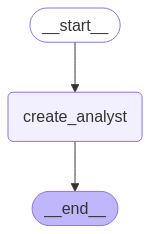

In [63]:
display(Image(create_analyst_graph.get_graph(xray=1).draw_mermaid_png()))

In [65]:
# Input
max_analysts = 3
topic = grade_meal_documents[0].query
graded_meal_documents = grade_meal_documents
# thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in create_analyst_graph.stream({"max_analysts": max_analysts,
                                          "meal_queries": queries_info, "user_profile": user_profile},
                                         stream_mode="values"):
    # Review
    meal_type_analysts_event: MealTypeAnalysts = event
    meal_type_analysts = meal_type_analysts_event.get("analysts", "")

    if meal_type_analysts:
        for analysts in meal_type_analysts:
            meal_type_analysts = analysts.analysts
            for analyst in meal_type_analysts:
                print(f"Name: {analyst["name"]}")
                print(f"Tone: {analyst["tone"]}")
                print(f"Theme: {analyst["theme"]}")
                print(f"Description: {analyst["description"]}")
                print("-" * 50)

Name: Protein Pete
Tone: Energetic
Theme: High-Protein Breakfast
Description: Protein Pete is here to pump up your breakfast with high-protein options that fit your dairy-free and low-carb lifestyle. He suggests meals like scrambled eggs with spinach and turkey bacon or a tofu scramble with avocado to keep you energized and satisfied throughout the morning.
--------------------------------------------------
Name: Carb-Conscious Carla
Tone: Practical
Theme: Low-Carb Options
Description: Carb-Conscious Carla focuses on providing you with low-carb breakfast ideas that align with your dietary preferences. She recommends dishes like almond flour pancakes with a side of berries or a chia seed pudding made with coconut milk to help you maintain your weight while enjoying a delicious start to your day.
--------------------------------------------------
Name: Allergy-Aware Alex
Tone: Caring
Theme: Allergy-Friendly Meals
Description: Allergy-Aware Alex ensures your breakfast is safe and peanut-f

# Conduct Interview

In [101]:
class SourcedDocuments(TypedDict):
    analyst: Analyst
    context: Annotated[list, operator.add]  # Source docs


class InterviewState(TypedDict):
    max_num_turns: int  # Number turns of conversation
    sourced_documents: List[SourcedDocuments]
    analyst: List[Analyst]  # Analyst asking questions
    interview: str  # Interview transcript
    sections: list  # Final key we duplicate in outer state for Send() API
    analysts_messages: List[AnalystMessages]


class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Search query for retrieval.")

In [78]:
weight_maintenance_max = Analyst(
    name="Weight-Maintenance Max",
    tone="supportive",
    theme="Weight Maintenance",
    description=(
        "Max is focused on helping you maintain your current weight with balanced lunch options. "
        "He suggests meals like a grilled salmon fillet with a side of steamed broccoli and a small portion of sweet potato, "
        "or a tofu stir-fry with mixed vegetables. Max ensures your meals are portioned correctly to support your weight maintenance goal."
    )
)
weight_maintenance_max["theme"]

'Weight Maintenance'

In [89]:
question_template = """You are an analyst tasked with interviewing an expert to learn about a specific topic.

Your goal is boil down to interesting and specific insights related to your topic.

1. Interesting: Insights that people will find surprising or non-obvious.

2. Specific: Insights that avoid generalities and include specific examples from the expert.

Here is your topic of focus and set of goals: {goals}

Begin by introducing yourself using a name that fits your persona, and then ask your question.

Continue to ask questions to drill down and refine your understanding of the topic.

When you are satisfied with your understanding, complete the interview with: "Thank you so much for your help!"

Remember to stay in character throughout your response, reflecting the persona and goals provided to you.
"""


def generate_question(state: InterviewState):
    """ Node to generate a question """
    llm_chat = ChatOpenAI(
        model="gpt-4o",
        temperature=0,
        max_tokens=None,
        timeout=None,
        max_retries=2,
    )

    analysts: List[Analyst] = state["analyst"]
    analysts_messages: List[AnalystMessages] = state["analysts_messages"]

    # Generate questions
    for analyst in analysts:
        goals = f"Explore expert strategies related to {analyst["theme"].lower()} — specifically, {analyst["description"]}"
        system_message = question_template.replace("{goals}", goals)
        question = llm_chat.invoke([
            SystemMessage(content=system_message),
            HumanMessage(content="Let's begin.")
        ])

        analysts_messages.append(
            AnalystMessages(
                analyst=analyst,
                messages=[question],
            )
        )

    # Write messages to state
    return {"analysts_messages": [analysts_messages]}

# Generate Answers: Parallelization

In [107]:
tavily_search = TavilySearchResults(max_results=3)

# Search query writing
search_instructions = SystemMessage(content=f"""You will be given a conversation between an analyst and an expert.
ii
Your goal is to generate a well-structured query for use in retrieval and / or web-search related to the conversation.

First, analyze the full conversation.

Pay particular attention to the final question posed by the analyst.

Convert this final question into a well-structured web search query""")


def search_web(state: InterviewState):

    """ Retrieve docs from web search """

    structured_llm = llm.with_structured_output(SearchQuery)
    analysts:List[Analyst] = state["analyst"]
    sourced_documents:List[SourcedDocuments] = state["sourced_documents"]

    for analyst in analysts:
        messages = analyst["messages"]
        search_query = structured_llm.invoke([search_instructions]+messages)
        # Search
        search_docs = tavily_search.invoke(search_query.search_query)

         # Format
        formatted_search_docs = "\n\n---\n\n".join(
            [
                f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
                for doc in search_docs
            ]
        )

        sourced_documents.append(
            SourcedDocuments(
                analyst=analyst,
                context=[formatted_search_docs],
            )
        )

    return {"sourced_documents": [sourced_documents]}

def search_wikipedia(state: InterviewState):
    """ Retrieve docs from wikipedia """

    structured_llm = llm.with_structured_output(SearchQuery)
    analysts:List[Analyst] = state["analyst"]
    sourced_documents:List[SourcedDocuments] = state["sourced_documents"]

    for analyst in analysts:
        messages = analyst["messages"]
        search_query = structured_llm.invoke([search_instructions]+messages)
        # Search
        search_docs = WikipediaLoader(query=search_query.search_query,
                                  load_max_docs=2).load()

         # Format
        formatted_search_docs = "\n\n---\n\n".join(
            [
                f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
                for doc in search_docs
            ]
        )

        sourced_documents.append(
            SourcedDocuments(
                analyst=analyst,
                context=[formatted_search_docs],
            )
        )

    return {"sourced_documents": [sourced_documents]}

answer_instructions = """You are an expert being interviewed by an analyst.

Here is analyst area of focus: {goals}.

You goal is to answer a question posed by the interviewer.

To answer question, use this context:

{context}

When answering questions, follow these guidelines:

1. Use only the information provided in the context.

2. Do not introduce external information or make assumptions beyond what is explicitly stated in the context.

3. The context contain sources at the topic of each individual document.

4. Include these sources your answer next to any relevant statements. For example, for source # 1 use [1].

5. List your sources in order at the bottom of your answer. [1] Source 1, [2] Source 2, etc

6. If the source is: <Document source="assistant/docs/llama3_1.pdf" page="7"/>' then just list:

[1] assistant/docs/llama3_1.pdf, page 7

And skip the addition of the brackets as well as the Document source preamble in your citation."""

def generate_answer(state: InterviewState):

    """ Node to answer a question """

    # Get state
    analysts:List[Analyst] = state["analyst"]
    sourced_documents:List[SourcedDocuments] = state["sourced_documents"]
    analysts_messages:List[AnalystMessages] = state["analysts_messages"]

    # analyst = state["analyst"]
    # messages = state["messages"]
    # context = state["context"]

    for analyst in analysts:
        messages = analyst["messages"]
        i = next(
            (i for i, analyst_message in enumerate(analysts_messages) if analyst_message["analyst"]["name"] == analyst_message["name"]),
            -1
        )
        context = list(
            filter(lambda doc: doc["analyst"]["name"] == Analyst, sourced_documents)
        )

        # Answer question
        system_message = answer_instructions.format(goals=analyst.persona, context=context)
        answer = llm.invoke([SystemMessage(content=system_message)]+messages)

        # Name the message as coming from the expert
        answer.name = "expert"
        # Answer the question in the user stte
        analysts_messages[i]["messages"] = [answer]

    return {"analysts_messages": analysts_messages}

Now, we create nodes to search the web and wikipedia.

We'll also create a node to answer analyst questions.

Finally, we'll create nodes to save the full interview and to write a summary ("section") of the interview.